# Effectiveness of Drugs using LSTM and RandomForestRegressor

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt #for plotting
import pandas as pd #data manipulation
import re
from keras.layers import LSTM, Dense, Dropout, Embedding
from keras.models import Sequential
from keras.models import load_model

from sklearn.preprocessing import MinMaxScaler #scaling the data
from sklearn.metrics import mean_squared_error, mean_squared_error #for model evaluation
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

# fix random seed for reproducibility
np.random.seed(1)

Using TensorFlow backend.


## The Data

In [2]:
# Loading the data
data = pd.read_csv("csv/medicine.csv")

In [3]:
print('Number of rows and columns:', data.shape)

Number of rows and columns: (32165, 8)


In [4]:
data.head()

,patient_id,name_of_drug,use_case_for_drug,review_by_patient,effectiveness_rating,drug_approved_by_UIC,number_of_times_prescribed,base_score
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9,20-May-12,27,8.022969
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8,27-Apr-10,192,7.858458
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5,14-Dec-09,17,6.341969
3,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9,27-Nov-16,37,6.590176
4,155963,Cialis,Benign Prostatic Hyperplasia,"""2nd day on 5mg started to work with rock hard...",2,28-Nov-15,43,6.144782


In [5]:
# checking the total count, null values, data type
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32165 entries, 0 to 32164
Data columns (total 8 columns):
patient_id                    32165 non-null int64
name_of_drug                  32165 non-null object
use_case_for_drug             32165 non-null object
review_by_patient             32165 non-null object
effectiveness_rating          32165 non-null int64
drug_approved_by_UIC          32165 non-null object
number_of_times_prescribed    32165 non-null int64
base_score                    32165 non-null float64
dtypes: float64(1), int64(3), object(4)
memory usage: 2.0+ MB


In [6]:
data.base_score.describe()

count    32165.000000
mean         6.664261
std          1.588699
min          0.899076
25%          6.109307
50%          6.788245
75%          7.900790
max          8.992453
Name: base_score, dtype: float64

## Text Preprocessing

In [7]:
def cleanHTML(review):
    cleaner = re.compile('<.*?>')
    clean_review = re.sub(cleaner, ' ', review)
    return clean_review

def cleanPunc(review):
    cleaned = re.sub(r'[?|!|\'|\"|#]', r'', review)
    cleaned = re.sub(r'[.|,|)|(|\|/]', r' ', cleaned)
    return cleaned

def decontracted(phrase):
    # specific
    phrase = re.sub(r"&#039;", "\'", phrase)
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [8]:
data.review_by_patient = data.review_by_patient.apply(cleanHTML)
data.review_by_patient = data.review_by_patient.apply(decontracted)
data.review_by_patient = data.review_by_patient.apply(cleanPunc)

## Corpus creation

In [9]:
corpus = {}
for rev in data.review_by_patient.values:
    rev = rev.lower()
    for word in rev.strip().split():
        if len(word) > 2:
            if word in corpus.keys():
                corpus[word] += 1
            else:
                corpus[word] = 1

In [10]:
sorted_corpus = sorted(corpus.items(), key=lambda x:x[1], reverse=True)
# using top 5000 words
top_words = 5000
sorted_corpus = sorted_corpus[:top_words]
corpus_rank = {}
for i in range(len(sorted_corpus)-1):
    corpus_rank[sorted_corpus[i][0]] = i+1

In [11]:
review = data.review_by_patient

In [12]:
# word to vector formation
review = review.apply(lambda x:[corpus_rank.get(word) for word in x.strip().split()
                                if corpus_rank.get(word, -1) != -1])

In [13]:
review.apply(lambda x:len(x)).describe()

count    32165.000000
mean        56.411223
std         29.828022
min          0.000000
25%         32.000000
50%         56.000000
75%         83.000000
max        443.000000
Name: review_by_patient, dtype: float64

In [14]:
review.head()

0                            [19, 17, 155, 25, 802, 1]
1    [553, 2818, 180, 447, 1651, 51, 331, 1156, 40,...
2    [114, 25, 218, 1017, 1719, 62, 9, 48, 483, 1, ...
3    [19, 219, 715, 64, 186, 41, 2191, 392, 1, 177,...
4    [549, 14, 442, 28, 82, 11, 2294, 316, 2143, 16...
Name: review_by_patient, dtype: object

In [15]:
# choose a length for vector and making same length vector using padding
max_len = 150
from keras.preprocessing.sequence import pad_sequences
padded = pad_sequences(review.values, maxlen=max_len,padding='pre', truncating='pre')

In [16]:
padded.shape

(32165, 150)

## Normalizing

In [17]:
target_data = data.base_score.values.reshape(-1,1)
scaler = MinMaxScaler()
scaled = scaler.fit_transform(target_data)

In [18]:
X, val_X, test_X = padded[:25000], padded[25000:29000], padded[29000:]
y, val_y, test_y = scaled[:25000], scaled[25000:29000], scaled[29000:]

## featurization using deep learning model

In [19]:
model = Sequential()
model.add(Embedding(top_words, 32, input_length=max_len))
model.add(LSTM(32, kernel_regularizer='l2'))
model.add(Dropout(0.2))
model.add(Dense(1))

In [20]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 150, 32)           160000    
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 168,353
Trainable params: 168,353
Non-trainable params: 0
_________________________________________________________________


In [21]:
model.compile(optimizer='adam', loss='mse')

In [22]:
model.fit(X, y, epochs=3,batch_size=72, shuffle=False, validation_data=(val_X, val_y))

# model = load_model('medicine_review_score')

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 25000 samples, validate on 4000 samples
Epoch 1/3
25000/25000 [==============================] - 41s 2ms/step - loss: 0.1513 - val_loss: 0.0393
Epoch 2/3
25000/25000 [==============================] - 43s 2ms/step - loss: 0.0405 - val_loss: 0.0383
Epoch 3/3
25000/25000 [==============================] - 43s 2ms/step - loss: 0.0388 - val_loss: 0.0385


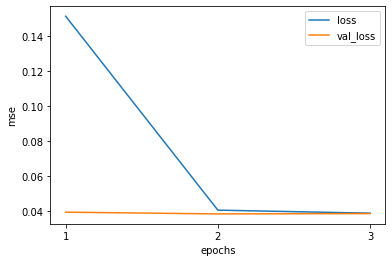

In [23]:
plt.plot(model.history.history['loss'])
plt.plot(model.history.history['val_loss'])
plt.xticks([0,1,2], [1,2,3])
plt.legend(['loss', 'val_loss'])
plt.xlabel("epochs")
plt.ylabel('mse')
plt.show()

In [24]:
model.save('review_score.h5')

In [25]:
# performance at unseen data
mean_squared_error(model.predict(test_X),test_y)

0.03714893489920602

In [26]:
pred = model.predict(test_X)
pred = scaler.inverse_transform(pred)
y_act = scaler.inverse_transform(test_y)
mean_absolute_error(pred,y_act)

1.2148798719970952

In [27]:
df = data[['effectiveness_rating','number_of_times_prescribed','base_score']]
df['review_score'] = scaler.inverse_transform(model.predict(padded))
df = df.reindex(columns=['effectiveness_rating','number_of_times_prescribed','review_score','base_score'])
df.head()

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,effectiveness_rating,number_of_times_prescribed,review_score,base_score
0,9,27,6.925408,8.022969
1,8,192,7.062912,7.858458
2,5,17,6.802519,6.341969
3,9,37,7.785662,6.590176
4,2,43,6.841665,6.144782


In [28]:
scaler_d = MinMaxScaler()
scaled_d = scaler_d.fit_transform(df)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype float32, int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [29]:
from sklearn.model_selection import train_test_split
X_train, X_test,y_train, y_test = train_test_split(scaled_d[:,:-1], scaled_d[:,-1], test_size = 0.3)
X_train.shape, y_train.shape

((22515, 3), (22515,))

## Machine Learning Model

In [33]:
from sklearn.ensemble import RandomForestRegressor
reg = RandomForestRegressor(30)
reg.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=30, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [34]:
mean_squared_error(y_test, reg.predict(X_test))

0.0009401463753589932

In [35]:
reg.score(X_test, y_test)

0.9760255959964914

In [36]:
model.save('medicine_review_score')

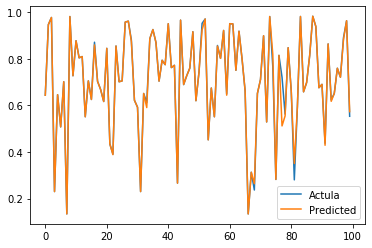

In [37]:
import matplotlib.pyplot as plt

plt.plot(y_test[100:200], label = 'Actula')
plt.plot(reg.predict(X_test[100:200]), label = 'Predicted')
plt.legend()
plt.show()

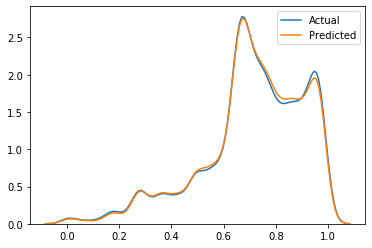

In [38]:
import seaborn as sn
sn.kdeplot(y_test, label = 'Actual')
sn.kdeplot(reg.predict(X_test), label = 'Predicted')

In [47]:
pred = reg.predict(X_test)
pred = pred * scaler_d.data_range_[-1] + scaler_d.data_min_[-1]
y_act = y_test * scaler_d.data_range_[-1] + scaler_d.data_min_[-1]
mean_absolute_error(pred,y_act), mean_squared_error(pred, y_act)

(0.05609882730601262, 0.06158218117722316)

In [48]:
drugs = data.use_case_for_drug.values
len(list(set(drugs)))

636

In [50]:
data[data.use_case_for_drug=='Erectile Dysfunction'].sort_values(by='base_score', ascending=False)[['name_of_drug','review_by_patient','base_score']].head(2).values

array([['Tadalafil',
        'Suffered with ED for years   Had slowly gotten worse to the point of zero erections   My Urologist prescribed Cialis   The first time I tried it results were poor a few flacid short lived erections   I called my doctor and he said try again as it might not work the first time   The second time was fantastic   The second time almost as good as the first   The third time poor results only one erection capable of intercourse   The fourth time even worse  fifth time nothing at all   Switched to Viagra on Dr s suggestion   Cialis side effects were moderate headache  moderate back ache  stuffiness and sinus pressure ',
        8.944722732824957],
       ['Viagra',
        'I hear a lot about buying viagra and other medications outside the United States and I can only tell from personal experience that it all works well  I get the pills for my dude from outside United states for quite some time now and do not encounter any problems \r\nIt is just big pharma do no